# Brown Bag Seminar: Operating Rooms Scheduling using Genetic Algorithm

By Ronie Arauco

<center><img src="https://miro.medium.com/max/1400/0*9N4FFhtZUd95pAGF" alt="drawing" width="550"/></center>

The problem and data was proposed in the Schedule Optimisation using Linear Programming in Python article by Lewis Woolfsoon (https://towardsdatascience.com/schedule-optimisation-using-linear-programming-in-python-9b3e1bc241e1). The problem aims to maximize the operating rooms occupation and drive the next statements:
1. **Sessions:** Availability hours of operating rooms
2. **Cases:** Operations to be assigned to a session.
Unlike Lewis solution, Genetic Algorithms are used for optimization challenge.

The start time of a case must be after the start time of the session it is assigned to
* A case must end before the end of its allocated session
* A case can be assigned to at most one session
* Cases cannot be assigned to a session after their deadline date
* No two cases can overlap: the start time of one case must be after the end time of another case
* The utilisation of a session is equal to the fraction of the session duration that is taken up by surgical cases
* The utilisation must be between 0 and 85\% (because 15\% of the session must be kept free for other activities).

**Objective:** maximize utilisation of sessions



In [ ]:
!pip install plotnine==0.8.0

In [2]:
import numpy as np
import pandas as pd
import random
import time
from copy import deepcopy
from plotnine import ggplot, aes, geom_line, theme_bw, labs, theme, scale_y_continuous
from mizani.formatters import scientific_format

Data is extracted from Lewis Github repository.

In [3]:
!curl -L -O "https://raw.githubusercontent.com/Lewisw3/theatre-scheduling/master/data/{cases,sessions}.csv"


[1/2]: https://raw.githubusercontent.com/Lewisw3/theatre-scheduling/master/data/cases.csv --> cases.csv
--_curl_--https://raw.githubusercontent.com/Lewisw3/theatre-scheduling/master/data/cases.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1629  100  1629    0     0  31326      0 --:--:-- --:--:-- --:--:-- 31326

[2/2]: https://raw.githubusercontent.com/Lewisw3/theatre-scheduling/master/data/sessions.csv --> sessions.csv
--_curl_--https://raw.githubusercontent.com/Lewisw3/theatre-scheduling/master/data/sessions.csv
100   277  100   277    0     0  23083      0 --:--:-- --:--:-- --:--:-- 23083


Dates need to be formatted to facilitate data manipulation.

In [4]:
# Casos
df_cases = pd.read_csv("cases.csv")
df_cases["TargetDeadline"] = \
  pd.to_datetime(df_cases["TargetDeadline"], format="%d/%m/%Y")

# Sesiones
df_sessions = pd.read_csv("sessions.csv")
unassigned_id = 9999
df_sessions = pd.concat([df_sessions, \
  pd.DataFrame( \
    [[unassigned_id, "01/01/2020", "08:30:00", "18:00:00", 570, 1, "Unassigned"]], \
      columns=df_sessions.columns)], ignore_index=True)
df_sessions["Date"] = pd.to_datetime(df_sessions["Date"], format="%d/%m/%Y")

Sample of cases and sessions is shown below. A new session with specialty "Unassigned" is added because not all cases will fit the availability of sessions.

In [5]:
df_cases.head()

,CaseID,ConsultantID,Procedure,Speciality,Expected Duration,TargetDeadline
0,1,C011,Cataract Surgery,Ophthalmology,45,2020-07-07
1,2,C011,Vitrectomy,Ophthalmology,70,2020-07-17
2,3,C011,Cataract Surgery,Ophthalmology,45,2020-06-05
3,4,C011,Cataract Surgery,Ophthalmology,45,2020-06-28
4,5,C011,Cataract Surgery,Ophthalmology,45,2020-07-22


In [6]:
df_sessions

,SessionID,Date,Start,End,Duration,ConsultantID,Specialty
0,1001,2020-06-03,08:30:00,18:00:00,570,11,Ophthalmology
1,1002,2020-06-10,08:30:00,18:00:00,570,11,Ophthalmology
2,1003,2020-06-17,08:30:00,18:00:00,570,11,Ophthalmology
3,1004,2020-06-25,08:30:00,13:00:00,270,11,Ophthalmology
4,9999,2020-01-01,08:30:00,18:00:00,570,1,Unassigned


Individual class and their genetic operations are implemented. The representation of the problem is a chromosome of integers.

In [7]:
class Individual:   
  def __init__(self, chromosome):
    self.chromosome = chromosome[:]
    self.fitness = -1

  def crossover_onepoint(self, other):
    c = random.randrange(len(self.chromosome))
    ind1 = \
      Individual(self.chromosome[:c] + other.chromosome[c:])
    ind2 = \
      Individual(other.chromosome[:c] + self.chromosome[c:])
    return [ind1, ind2]

  def crossover_uniform(self, other):
    chromosome1 = []
    chromosome2 = []
    for i in range(len(self.chromosome)):
      if random.uniform(0, 1) < 0.5:
        chromosome1.append(self.chromosome[i])
        chromosome2.append(other.chromosome[i])
      else:
        chromosome1.append(other.chromosome[i])
        chromosome2.append(self.chromosome[i])
    ind1 = Individual(chromosome1)
    ind2 = Individual(chromosome2)
    return [ind1, ind2]

  def mutate_position(self):
    mutated_chromosome = deepcopy(self.chromosome)
    mut_gene = random.randrange(0, len(mutated_chromosome))
    new_allele = \
      allele_pool["sessions"][random.randrange(0, len(allele_pool))].id
    mutated_chromosome[mut_gene] = new_allele
    return Individual(mutated_chromosome)

  def mutate_swap(self):
    mutated_chromosome = deepcopy(self.chromosome)
    mut_gen1 = random.randrange(0, len(mutated_chromosome))
    mut_gen2 = random.randrange(0, len(mutated_chromosome))
    temp = mutated_chromosome[mut_gen1]
    mutated_chromosome[mut_gen1] = mutated_chromosome[mut_gen2]
    mutated_chromosome[mut_gen2] = temp
    return Individual(mutated_chromosome)

Cases and sessions have their own classes and attributes.

In [8]:
class Case:
  def __init__(self, id, procedure, exp_dur, deadline):
    self.id = id
    self.procedure = procedure
    self.exp_dur = exp_dur
    self.deadline = deadline

class Session:
  def __init__(self, id, date, start, end, dur, consultant_id, specialty):
    self.id = id
    self.date = date
    self.start = start
    self.end = end
    self.dur = dur
    self.consultant_id = consultant_id
    self.specialty = specialty

Population is randomly initialized. The chromosome representation length is equal to the number of cases and each gene can take session ID values (alleles). For instance, [1001, 1004, 1001, 1003, 1002, 1] is a chromosome that represents 6 cases and 4 sessions.

In [9]:
def init_population(pop_number, chromosome_size, sessions):
  aux_sessions = [s.id for s in sessions]
  population = [ \
    Individual([np.random.choice(aux_sessions, replace=True) \
      for i in range(chromosome_size)]) \
      for _ in range(pop_number)
  ]
  return population

Fitness function aims to increase according to the number of cases assigned in sessions. Constraints are also applied here. For instance, a schedule that overpasses the 15% of free time is penalized with 0 fitness.

In [10]:
def operating_room_fitness(chromosome, sessions, cases):
    session_time = 0
    invalid = False
    free_time = 0.15
    for s in sessions:
      time_used = 0
      for j in range(len(chromosome)):
        if chromosome[j] == s.id and chromosome[j] != unassigned_id:
          if time_used + cases[j].exp_dur <= s.dur * (1 - free_time) and \
            cases[j].deadline >= s.date:
            time_used += cases[j].exp_dur
          else:
            session_time = 0
            invalid = True
            break
      if invalid:
        break
      session_time += time_used / s.dur
    return session_time / (len(sessions) - 1)

def evaluate_population(population, fitness_fn, sessions, cases):
    popsize = len(population)
    for i in range(popsize):
      if population[i].fitness == -1:
        population[i].fitness = fitness_fn(population[i].chromosome, \
          sessions, cases)

In [11]:
def select_parents_roulette(population):
  popsize = len(population)
  sumfitness = sum([indiv.fitness for indiv in population])
  pickfitness = random.uniform(0, sumfitness)
  cumfitness = 0
  iparent1 = random.randint(0, popsize - 1)
  for i in range(popsize):
    cumfitness += population[i].fitness
    if cumfitness > pickfitness: 
      iparent1 = i
      break
  sumfitness = sumfitness - population[iparent1].fitness
  pickfitness = random.uniform(0, sumfitness)
  cumfitness = 0
  iparent2 = random.randint(0, popsize - 1)
  for i in range(popsize):
    if i == iparent1: continue
    cumfitness += population[i].fitness
    if cumfitness > pickfitness: 
      iparent2 = i
      break        
  return (population[iparent1], population[iparent2])

def select_parents_tournament(population, size_tournament):
  list_indiv=[]
  x1 = np.random.permutation(len(population))
  y1 = x1[0:size_tournament]
  for i in range(size_tournament):
    list_indiv.append(population[y1[i]].fitness)
  iparent1 = np.argmax(list_indiv)
  x2 = np.delete(x1, iparent1)
  x2 = np.random.permutation(x2)
  list_indiv = []
  y2 = x2[0:size_tournament]
  for i in range(size_tournament):
    list_indiv.append(population[y2[i]].fitness)
  iparent2 = np.argmax(list_indiv)
  return (population[x1[iparent1]],population[x2[iparent2]])

In [12]:
def select_survivors(population, offspring_population, numsurvivors):
  next_population = []
  population.extend(offspring_population)
  isurvivors = \
    sorted(range(len(population)), key=lambda i: population[i].fitness, \
      reverse=True)[:numsurvivors]
  for i in range(numsurvivors):
    next_population.append(population[isurvivors[i]])
  return next_population

In [13]:
def genetic_algorithm(population, fitness_fn, sessions, cases, ngen, \
  selection_method, size_tournament, pmut, crossover, mutation):
  popsize = len(population)
  evaluate_population(population, fitness_fn, sessions, cases)
  ibest = \
    sorted(range(len(population)), key=lambda i: population[i].fitness, \
      reverse=True)[:1]  
  bestfitness = [population[ibest[0]].fitness]  
  print(f"Initial population, best_fitness = {population[ibest[0]].fitness}")
  
  for g in range(ngen):
    mating_pool = []
    if selection_method=="roulette":
      for i in range(int(popsize/2)):
        mating_pool.append(select_parents_roulette(population)) 
    elif selection_method=="tournamentsize_tournament" :
      for i in range(int(popsize/2)):
        mating_pool.append(select_parents_tournament(population, \
          size_tournament)) 

    offspring_population = []
    for i in range(len(mating_pool)): 
      if crossover == "onepoint":
        offspring_population.extend( \
          mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) 
      elif crossover == "uniform":
        offspring_population.extend( \
          mating_pool[i][0].crossover_uniform(mating_pool[i][1])) 

    for i in range(len(offspring_population)):
      if random.uniform(0, 1) < pmut: 
        if mutation == "position":
          offspring_population[i] = offspring_population[i].mutate_position()   
        elif mutation == "swap":
          offspring_population[i] = offspring_population[i].mutate_swap()      

    evaluate_population(offspring_population, fitness_fn, sessions, cases)  

    population = select_survivors(population, offspring_population, popsize)

    ibest = \
      sorted(range(len(population)), key=lambda i: population[i].fitness, \
        reverse=True)[:1]
    bestfitness.append(population[ibest[0]].fitness)
    
    best_schedule = population[ibest[0]].chromosome
    print(f"Generation {g}, Best individual = {best_schedule} (fitness = {population[ibest[0]].fitness})")

  return population[ibest[0]], bestfitness  

In [14]:
cases = []
for _, case in df_cases.iterrows():
  aux_case = Case(
    case["CaseID"],
    case["Procedure"],
    case["Expected Duration"],
    case["TargetDeadline"]
  )
  cases.append(aux_case)

sessions = []
for _, session in df_sessions.iterrows():
  aux_session = Session(
    session["SessionID"],
    session["Date"],
    session["Start"],
    session["End"],
    session["Duration"],
    session["ConsultantID"],
    session["Specialty"]
  )
  sessions.append(aux_session)

allele_pool = {
  "sessions": sessions,
  "cases": cases
}

In [22]:
num_individuals = 3000
population = \
  init_population(num_individuals, len(allele_pool["cases"]), \
    allele_pool["sessions"])

fitness_fn = operating_room_fitness

ngen = 100
pmut = 0.8

selection_method = ["roulette", "tournament"]
k_tournament = 5
size_tournament = int(k_tournament * num_individuals / 100)

crossover = ["onepoint", "uniform"]
mutation = ["position", "onepoint"]

best_ind, bestfitness = genetic_algorithm(population, fitness_fn, \
  sessions, cases, ngen, selection_method[0], size_tournament, pmut, \
  crossover[0], mutation[1])

Initial population, best_fitness = 0.7127192982456141
Generation 0, Best individual = [1001, 1001, 9999, 1004, 9999, 9999, 1004, 1002, 1001, 1001, 1004, 1002, 9999, 9999, 1003, 1002, 1004, 1002, 1002, 1002, 1002, 1003, 1002, 1001, 1001, 1004, 1001, 1003, 1003, 1003] (fitness = 0.7324561403508772)
Generation 1, Best individual = [1004, 1003, 9999, 1003, 1001, 1004, 1001, 9999, 1001, 1001, 1004, 1002, 9999, 9999, 1003, 1002, 1004, 1002, 1002, 1002, 1002, 1003, 1002, 1001, 1001, 1004, 1003, 9999, 1003, 1001] (fitness = 0.7390350877192983)
Generation 2, Best individual = [1004, 1003, 9999, 1003, 1001, 1004, 1001, 9999, 1001, 1001, 1004, 1002, 9999, 9999, 1003, 1002, 1004, 1002, 1002, 1002, 1002, 1003, 1002, 1001, 1001, 1004, 1003, 9999, 1003, 1001] (fitness = 0.7390350877192983)
Generation 3, Best individual = [9999, 1001, 9999, 1004, 1003, 1001, 1004, 1001, 9999, 9999, 1002, 1004, 1003, 9999, 1003, 1002, 1001, 1002, 1002, 1002, 1001, 1001, 1001, 1004, 1001, 1004, 1001, 1003, 1003, 1003] (

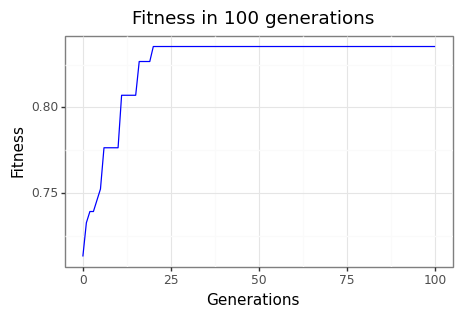

<ggplot: (8728004885585)>

In [23]:
(
  ggplot(aes(range(ngen + 1), bestfitness)) + \
  geom_line(colour="blue") + \
  theme_bw() + \
  labs(title=f"Fitness in {ngen} generations", x="Generations", y="Fitness") + \
  theme(figure_size=(5, 3))
)

In [24]:
print("================ Final Report ================")
for i in range(len(allele_pool["sessions"])):
  total_dur = 0
  for j in range(len(best_ind.chromosome)):
    if allele_pool["sessions"][i].id == best_ind.chromosome[j]:
      print("Cases:", allele_pool["cases"][j].id, "\t Exp Dur:", \
        allele_pool["cases"][j].exp_dur, "\t Session:", \
          allele_pool["sessions"][i].id, "\t Deadline:", \
            allele_pool["cases"][j].deadline, "\t Session Availability:", \
              allele_pool["sessions"][i].date)
      total_dur += allele_pool["cases"][j].exp_dur
  print("** Total duration in session:", total_dur, "minutes (", total_dur * 100 / allele_pool["sessions"][i].dur, "% )")

================ Final Report ================
Cases: 1 	 Exp Dur: 45 	 Session: 1001 	 Deadline: 2020-07-07 00:00:00 	 Session Availability: 2020-06-03 00:00:00
Cases: 2 	 Exp Dur: 70 	 Session: 1001 	 Deadline: 2020-07-17 00:00:00 	 Session Availability: 2020-06-03 00:00:00
Cases: 3 	 Exp Dur: 45 	 Session: 1001 	 Deadline: 2020-06-05 00:00:00 	 Session Availability: 2020-06-03 00:00:00
Cases: 7 	 Exp Dur: 45 	 Session: 1001 	 Deadline: 2020-07-03 00:00:00 	 Session Availability: 2020-06-03 00:00:00
Cases: 9 	 Exp Dur: 70 	 Session: 1001 	 Deadline: 2020-07-04 00:00:00 	 Session Availability: 2020-06-03 00:00:00
Cases: 10 	 Exp Dur: 45 	 Session: 1001 	 Deadline: 2020-07-14 00:00:00 	 Session Availability: 2020-06-03 00:00:00
Cases: 24 	 Exp Dur: 45 	 Session: 1001 	 Deadline: 2020-07-06 00:00:00 	 Session Availability: 2020-06-03 00:00:00
Cases: 25 	 Exp Dur: 70 	 Session: 1001 	 Deadline: 2020-06-08 00:00:00 	 Session Availability: 2020-06-03 00:00:00
Cases: 27 	 Exp Dur: 45 	 Sess